# Deep Mean Shift Clustering

## Reqs

In [0]:
!pip install mnist
from google.colab import drive
drive.mount('/content/gdrive/')
!pip install --upgrade torch torchvision

Mounted at /content/gdrive/
Requirement already up-to-date: torch in /usr/local/lib/python3.6/dist-packages (1.3.0+cu100)
Requirement already up-to-date: torchvision in /usr/local/lib/python3.6/dist-packages (0.4.1+cu100)


### Import

In [0]:
import mnist
import pickle
import torch
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets
import torchvision.transforms as transforms
import torch.optim as optim
from torch.autograd import Variable, Function, gradcheck
from itertools import cycle
from tqdm import tqdm

In [0]:
root = '/content/gdrive/My Drive/Deep Mean Shift Clustering/Experiments/'
torch.autograd.set_detect_anomaly(True)

## Dataset

### Download

In [0]:
trans = transforms.Compose([transforms.ToTensor()])
train = torchvision.datasets.MNIST(root+'data/', train=True, transform=trans, target_transform=None, download=True)
test = torchvision.datasets.MNIST(root+'data/', train=False, transform=trans, target_transform=None, download=True)

### Load

In [0]:
train_batch_size = 256
kernel_batch_size = 1024
test_batch_size = 256

train_loader = torch.utils.data.DataLoader(
                 dataset=train,
                 batch_size=train_batch_size,
                 shuffle=True)

#mean_shift batch
kernel_loader = torch.utils.data.DataLoader(
                 dataset=train,
                 batch_size=kernel_batch_size,
                 shuffle=True)

test_loader = torch.utils.data.DataLoader(
                dataset=test,
                batch_size=test_batch_size,
                shuffle=True)

print ('total trainning batch number: '+ str(len(train_loader)))
print ('total testing batch number: '+ str(len(test_loader)))

total trainning batch number: 235
total testing batch number: 40


## Plotter

In [0]:
def plot_regen(model, x_k):

    for batch_idx, (x, target) in enumerate(test_loader):

        train_image = x
        break

    fig=plt.figure(figsize=(10,40))

    num_im = 4
    for i in range(num_im):
        data = np.array(train_image[i], dtype='float')
        data = data.reshape((28, 28))
        ax = fig.add_subplot(1, num_im, i+1)
        plt.imshow(data, cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

    fig=plt.figure(figsize=(10,40))

    data = train_image.float()
    out = model(data.cuda(), x_k)[0]
    out = out.cpu().detach().numpy()

    num_im = 4
    for i in range(num_im):
        out1 = out[i].reshape((28, 28))
        out1 = np.array(out1, dtype='float')
        
        ax = fig.add_subplot(1, num_im, i+1)
        plt.imshow(out1, cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
    plt.show()


# AE Def

## Backbone + Regen

In [0]:
class AE(nn.Module):
    def __init__(self, z_len, ms_clust):
        super(AE, self).__init__()

        self.conv_1 = nn.Conv2d(1, 20, kernel_size=5, stride=1)
        self.pool = nn.MaxPool2d(2, 2, return_indices=True)
        self.ind1 = 0
        self.ind2 = 0
        self.conv_2 = nn.Conv2d(20, 50, kernel_size=5, stride=1)
        self.fc_1 = nn.Linear(4*4*50, 500)
        self.fc_2 = nn.Linear(500,z_len)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

        self.upfc_1 = nn.Linear(z_len, 500)
        self.upfc_2 = nn.Linear(500, 4*4*50)
        self.unpool = nn.MaxUnpool2d(2, 2)
        self.upconv_1 = nn.ConvTranspose2d(50, 20, kernel_size=5, stride=1)
        self.upconv_2 = nn.ConvTranspose2d(20, 1, kernel_size=5, stride=1)
        
        self.ms_clust = ms_clust

    def encode(self, x):
        z = self.conv_1(x)
        z = self.relu(z)
        z, self.ind1 = self.pool(z)
        z = self.conv_2(z)
        z = self.relu(z)
        z, self.ind2 = self.pool(z)
        z = z.view(z.size(0), -1)
        z = self.fc_1(z)
        z = self.relu(z)
        z = self.fc_2(z)
        z = F.normalize(z, p=2, dim=1)
        return z
    
    def decode(self, z):
        x = self.upfc_1(z)
        x = self.relu(x)
        x = self.upfc_2(x)
        x = x.view(x.size(0), 50, 4, 4)
        x = self.unpool(x, self.ind2)
        x = self.relu(x)
        x = self.upconv_1(x)
        x = self.unpool(x, self.ind1)
        x = self.relu(x)
        x = self.upconv_2(x)
        x = self.sigmoid(x)
        return x

    def forward(self, x, x_k):
        z_k = self.encode(x_k)
        z = self.encode(x)
        
        Tr, Tr_mask, A = self.ms_clust(z.t(), z_k.t())
        
        x_ = self.decode(Tr[:, -1, :])
        
        return x_, Tr, Tr_mask, A

## Mean Shift Cluster

In [0]:
class Mean_Shift_Cluster(torch.nn.Module):

    def __init__(self, lamb, delta, eta, T):
        super(Mean_Shift_Cluster, self).__init__()
        self.lamb = lamb #Bandwidth
        self.delta = delta #Bandwidth
        self.eta = eta #ascent rate
        self.T = T #Max time steps for mean shift
        self.D = None #D[i][j] is the density estimate of j^th update in trajectory of the i^th point
        # self.M = None #M[i] is the density estimate of the mode of the i^th point
        self.Tr = None #T-time steps long trajectory of each point
        self.Tr_mask = None #Mask to infer the actual length of trajectories
        self.A = None #A[i][j] = 1, if z_i and z_j have the same mode, 0 otherwise
        
    def calc_modes(self, X_k):
        X = self.Tr[-1]
        #Distance on sphere
        S = torch.mm(X_k.t(), X)
        #Kernel Evalutation
        K = torch.exp(self.lamb * S)
        #Weights
        k = X_k.shape[1]
        d = torch.mm(K.t(), torch.ones(k, 1).cuda())
        self.D = torch.cat((self.D, d/d.shape[0]), 1)
        #Modes
        self.M = self.D[:, -1]
        
    def calc_adj(self):
        X = self.Tr[-1].t()
        #f(Distance) on sphere
        S = torch.mm(X, X.t())
        #Distance on sphere
        dist = torch.acos(S)
        #constructing adjacency
        self.A = dist < torch.sqrt(torch.Tensor([self.lamb]).cuda())
    
    def calc_mask(self):
        #filter
        f = torch.eye(self.T+1)
        f_t = -1 * torch.ones(self.T)
        f = f + torch.diag(f_t, 1)
        f = f.cuda()
        #update progression
        diff = torch.mm(self.D, f)
        #convergence time mask
        self.Tr_mask = torch.abs(diff) > self.delta
        self.Tr_mask[:, 0] = True
        self.Tr_mask.requires_grad = False

    def mean_shift_once(self, X, X_k):   
        # print('X')
        # print(X)
        # #Distance on sphere
        S = torch.mm(X_k.t(), X)
        #Kernel Evalutation
        K = torch.exp(self.lamb * S)
        #Weights
        k = X_k.shape[1]
        d = torch.mm(K.t(), torch.ones(k, 1).cuda())
        
        if self.D is None:
            self.D = d/d.shape[0]
        else:
            self.D = torch.cat((self.D, d/d.shape[0]), 1)
        
        q = 1 / d
        D_inv = torch.diagflat(q)
        new_X = X + self.eta * (torch.mm(X_k, torch.mm(K, D_inv)) - X)
        new_norm_X = F.normalize(new_X, p=2, dim=0)
        
        return new_norm_X
  
    def forward(self, X, X_k):
        #init
        self.D = None 
        self.M = None
        self.Tr = None 
        self.Tr_mask = None 
        self.A = None 

        # dims: seq_len x z_len x batch_size
        self.Tr = torch.cat((X.unsqueeze(0), self.mean_shift_once(X, X_k).unsqueeze(0)))
        for it in range(1, self.T):
            self.Tr = torch.cat((self.Tr, self.mean_shift_once(self.Tr[-1], X_k).unsqueeze(0)))
        
        # modes
        self.calc_modes(X_k)
        self.calc_adj()
        self.calc_mask()
        
        # dims: batch_size x seq_len x z_len
        self.Tr = self.Tr.permute(2, 0, 1)
        
        return self.Tr, self.Tr_mask, self.A

## Loss

### Support Set Loss

In [0]:
class Support_Set_Loss(torch.nn.Module):

    def __init__(self, alpha):
        super(Support_Set_Loss, self).__init__()
        self.alpha = alpha
        
    def forward(self, Tr, Tr_mask, A):
        # loss weight for positive neighborhood
        A = -1 * (1 + self.alpha) * A + 1
        A_t = A.repeat(1, Tr.shape[1]).view(-1, A.shape[1])
        A_m = A_t[Tr_mask.flatten()]
        
        v = Tr.contiguous().view(-1, Tr.shape[-1])
        v = v[Tr_mask.flatten()]
        w = Tr[:, 0, :]
        
        #f(distance) on sphere
        f_dist = torch.mm(v, w.t())
        
        loss = torch.sum(f_dist * A_m) / Tr.shape[0]
        
        return loss

### DNN Loss

In [0]:
class DNN_Loss(torch.nn.Module):

    def __init__(self):
        super(DNN_Loss, self).__init__()
        self.mse = torch.nn.MSELoss(reduction='sum')

    def forward(self, X, X_):
        regen_loss = self.mse(X, X_)/X.shape[0]
        return regen_loss

## Weights

In [0]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.xavier_uniform_(m.weight.data)


# Model Init

## Params

In [0]:
alpha = 0.5 
eta = 1 
ms_iter = 10
lamb = 72
delta = 0.0005
total_epochs = 200
z_len = 64
#support set loss weight
c_loss_wt = 0.1


## Init

In [0]:
stext = 'support_set_ms_full_ngbr'
sname = 'checkpoints/support_set_ms_corr/'
save_dir = root + sname

f = open(save_dir + 'desc.txt', 'w+')
f.write(stext)
f.close()

ms_clust = Mean_Shift_Cluster(lamb, delta, eta, ms_iter)

# Load auto encoder
model = AE(z_len, ms_clust)
weights_init(model)
model = model.cuda().train()

support_set_loss = Support_Set_Loss(alpha)

dnn_loss = DNN_Loss()

optimizer = optim.Adam(model.parameters(), lr=0.01)

#mean_shift batch
kernel_loader = cycle(kernel_loader)

# Train

epoch: 0: 100%|██████████| 235/235 [00:54<00:00,  4.53it/s]



epoch 0 epoch avg loss 57.73225429616076
epoch 0 epoch avg cluster loss 33.13315965203529
epoch 0 epoch avg regen loss 24.59909456942944
Time taken for epoch: 0.92 min(s)



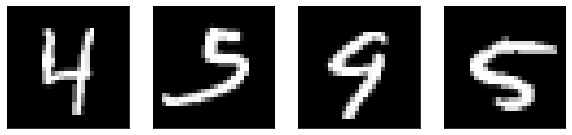

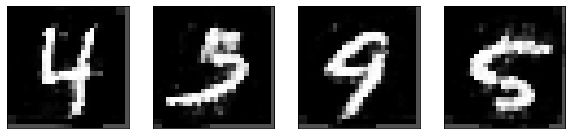

epoch: 1:   0%|          | 0/235 [00:00<?, ?it/s]

saving...



epoch: 1: 100%|██████████| 235/235 [00:55<00:00,  4.52it/s]



epoch 1 epoch avg loss 46.55739300098825
epoch 1 epoch avg cluster loss 36.69095194973844
epoch 1 epoch avg regen loss 9.866441036792512
Time taken for epoch: 0.92 min(s)



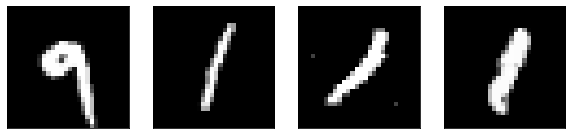

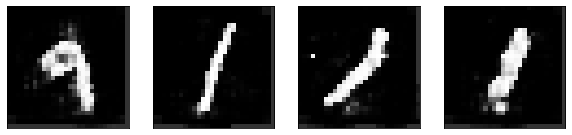

saving...



epoch: 2: 100%|██████████| 235/235 [00:55<00:00,  4.51it/s]



epoch 2 epoch avg loss 25.041098844244125
epoch 2 epoch avg cluster loss 17.16182448787892
epoch 2 epoch avg regen loss 7.879274968898042
Time taken for epoch: 0.92 min(s)



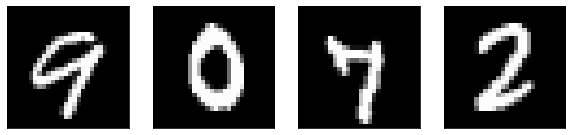

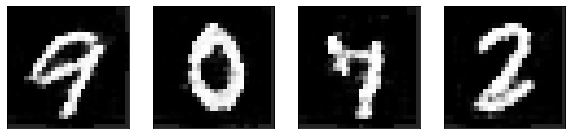

epoch: 3:   0%|          | 0/235 [00:00<?, ?it/s]

saving...



epoch: 3: 100%|██████████| 235/235 [00:54<00:00,  4.54it/s]



epoch 3 epoch avg loss 22.06479818060043
epoch 3 epoch avg cluster loss 14.949273553807684
epoch 3 epoch avg regen loss 7.115524373155959
Time taken for epoch: 0.91 min(s)



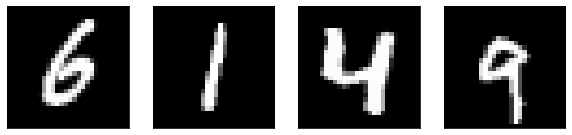

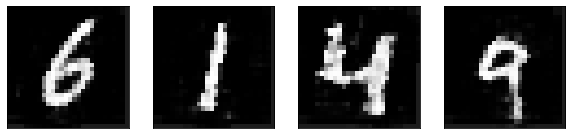

epoch: 4:   0%|          | 0/235 [00:00<?, ?it/s]

saving...



epoch: 4: 100%|██████████| 235/235 [00:54<00:00,  4.52it/s]



epoch 4 epoch avg loss 28.8617132775327
epoch 4 epoch avg cluster loss 22.182404160499573
epoch 4 epoch avg regen loss 6.679309595392105
Time taken for epoch: 0.91 min(s)



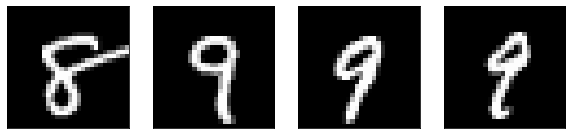

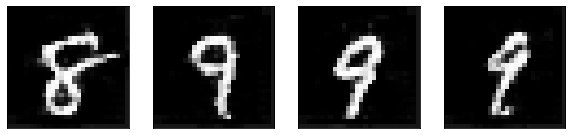

epoch: 5:   0%|          | 0/235 [00:00<?, ?it/s]

saving...



epoch: 5: 100%|██████████| 235/235 [00:55<00:00,  4.49it/s]



epoch 5 epoch avg loss 25.55056784913895
epoch 5 epoch avg cluster loss 19.373531937091908
epoch 5 epoch avg regen loss 6.177036056112736
Time taken for epoch: 0.92 min(s)



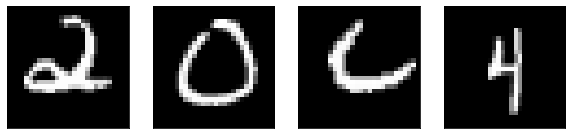

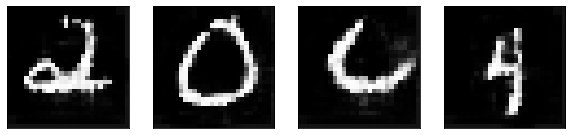

epoch: 6:   0%|          | 0/235 [00:00<?, ?it/s]

saving...



epoch: 6: 100%|██████████| 235/235 [00:55<00:00,  4.48it/s]



epoch 6 epoch avg loss 29.90185235206117
epoch 6 epoch avg cluster loss 24.291580739934393
epoch 6 epoch avg regen loss 5.610271409217347
Time taken for epoch: 0.92 min(s)



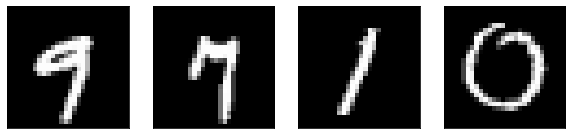

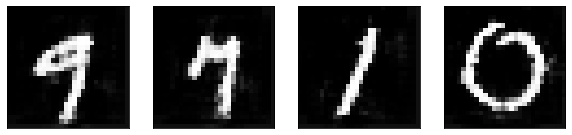

epoch: 7:   0%|          | 0/235 [00:00<?, ?it/s]

saving...



epoch: 7: 100%|██████████| 235/235 [00:55<00:00,  4.52it/s]



epoch 7 epoch avg loss 1.1977871042616823
epoch 7 epoch avg cluster loss -4.090090786142552
epoch 7 epoch avg regen loss 5.287877642854731
Time taken for epoch: 0.92 min(s)



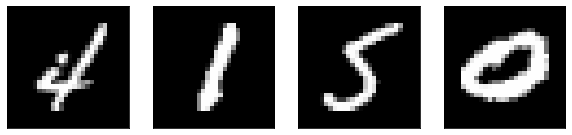

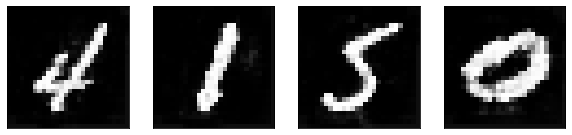

epoch: 8:   0%|          | 0/235 [00:00<?, ?it/s]

saving...



epoch: 8: 100%|██████████| 235/235 [00:55<00:00,  4.52it/s]



epoch 8 epoch avg loss 14.144805559198907
epoch 8 epoch avg cluster loss 9.021303818327315
epoch 8 epoch avg regen loss 5.123501254142599
Time taken for epoch: 0.93 min(s)



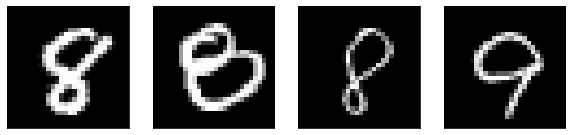

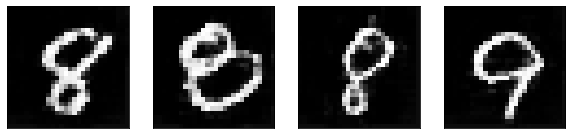

epoch: 9:   0%|          | 0/235 [00:00<?, ?it/s]

saving...



epoch: 9: 100%|██████████| 235/235 [00:55<00:00,  4.46it/s]



epoch 9 epoch avg loss 54.376824884211764
epoch 9 epoch avg cluster loss 47.26237487285695
epoch 9 epoch avg regen loss 7.114450115853168
Time taken for epoch: 0.93 min(s)



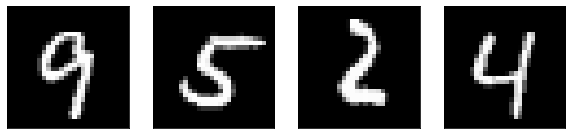

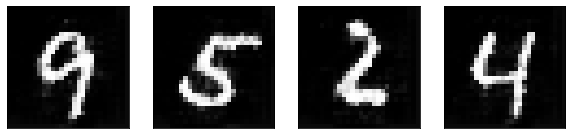

epoch: 10:   0%|          | 0/235 [00:00<?, ?it/s]

saving...



epoch: 10:  91%|█████████ | 213/235 [00:50<00:05,  4.22it/s]

KeyboardInterrupt: ignored

In [0]:
import time
from tqdm import tqdm

epoch_avg_total_loss = [0]*total_epochs

epoch_avg_cluster_loss = [0]*total_epochs

epoch_avg_regen_loss = [0]*total_epochs

total_loss_win = 0
cluster_loss_win = 0
regen_loss_win = 0

for epoch in range(total_epochs):
    
    #To time the code
    t = time.time()
    
    avg_total_loss = 0
    avg_cluster_loss = 0
    avg_regen_loss = 0
    total_batches = 0
    
    x_ngb, _ = next(kernel_loader)
    x_ngb.requires_grad = False
    x_ngb = x_ngb.cuda()
    
    for batch_idx, (x, target) in tqdm(enumerate(train_loader), total=len(train_loader), desc='epoch: '+str(epoch)):
        
        x, target = x.cuda(), target.numpy()
        # x itself will also contribute in kernel evaluation 
        x_k = torch.cat((x, x_ngb))
        x_k.requires_grad = False
        
        x_, Tr, Tr_mask, A  = model(x, x_k)

        cluster_loss = c_loss_wt * support_set_loss(Tr, Tr_mask, A)
        regen_loss = dnn_loss(x, x_)
        
        total_loss = cluster_loss + regen_loss
    
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        
        total_batches += 1
        
        avg_total_loss += total_loss.cpu().detach().numpy()
        avg_cluster_loss += cluster_loss.cpu().detach().numpy()
        avg_regen_loss += regen_loss.cpu().detach().numpy()

    #SAVE
    
    epoch_avg_total_loss[epoch] = avg_total_loss/total_batches
    epoch_avg_cluster_loss[epoch] = avg_cluster_loss/total_batches
    epoch_avg_regen_loss[epoch] = avg_regen_loss/total_batches
  
    loss_file = open(save_dir + 'loss_list.pkl', 'wb+')
    pickle.dump([epoch_avg_total_loss, epoch_avg_cluster_loss, epoch_avg_regen_loss], loss_file)
    loss_file.close()
    
    
    print()
    print('epoch', epoch, 'epoch avg loss', epoch_avg_total_loss[epoch])
    print('epoch', epoch, 'epoch avg cluster loss', epoch_avg_cluster_loss[epoch])
    print('epoch', epoch, 'epoch avg regen loss', epoch_avg_regen_loss[epoch])
    print("Time taken for epoch: %.2f min(s)" %((time.time() - t)/60))
    print()

    plot_regen(model, x)
    print('saving...')
    print()
    torch.save([model.state_dict(), optimizer.state_dict()], save_dir + 'model_' + str(epoch) + '.pt') 
  